<a href="https://colab.research.google.com/github/aaleksandraristic/ProjectSAP/blob/main/GAs_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.8 MB/s eta 0:00:00


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/content/final_dataset.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,APPL,ADBE,AMZN,CSCO,CRM,GOOGL,IBM,INTC,MSFT,NFLX,NVDA,NVDA.1,ORCL
Date,,,,,,,,,,,,,
2004-08-20,0.55,23.05,1.98,18.88,3.15,2.71,81.50,21.62,27.20,2.26,1.03,1.03,10.31
2004-08-23,0.56,22.82,1.97,19.18,3.13,2.74,80.93,21.89,27.24,2.27,1.05,1.05,10.30
2004-08-24,0.57,22.87,1.95,18.97,3.19,2.62,80.98,21.67,27.24,2.21,1.01,1.01,10.33
2004-08-25,0.59,23.12,2.02,19.32,3.24,2.65,81.33,21.95,27.55,2.24,1.06,1.06,10.40
2004-08-26,0.62,23.08,2.01,19.17,3.23,2.70,80.97,21.77,27.44,2.18,1.06,1.06,10.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19,175.46,555.74,128.40,53.32,208.32,137.75,138.01,35.67,331.32,401.77,421.01,421.01,108.34
2023-10-20,172.88,540.96,125.17,52.93,203.73,135.60,137.16,34.92,326.67,400.96,413.87,413.87,101.85
2023-10-23,173.00,540.41,126.56,52.20,202.00,136.50,136.38,33.85,329.32,406.84,429.75,429.75,103.66


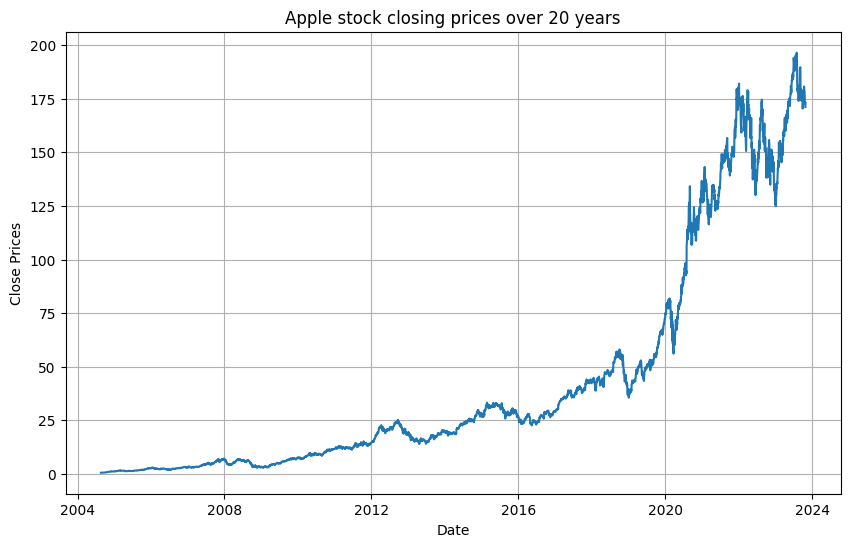

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['APPL'])
plt.title('Apple stock closing prices over 20 years')
plt.show()

<Axes: ylabel='Density'>

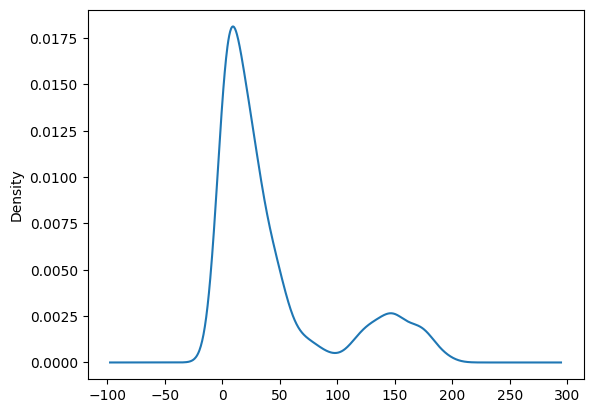

In [9]:
#Distribution of the dataset
df_close = stock_data['APPL']
df_close.plot(kind='kde')

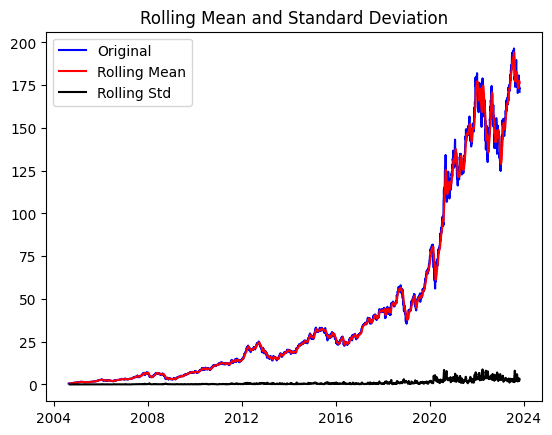

Results of dickey fuller test
Test Statistics                   1.028635
p-value                           0.994559
No. of lags used                 30.000000
Number of observations used    4798.000000
critical value (1%)              -3.431714
critical value (5%)              -2.862143
critical value (10%)             -2.567091
dtype: float64


In [10]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

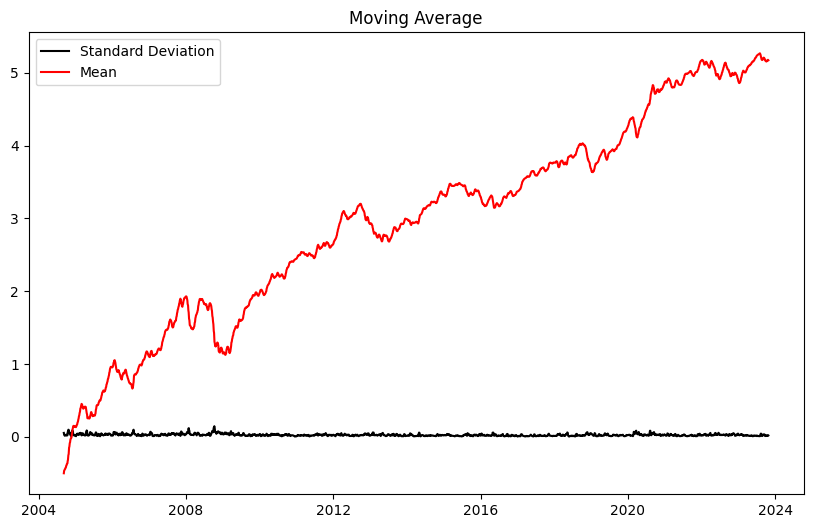

In [15]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

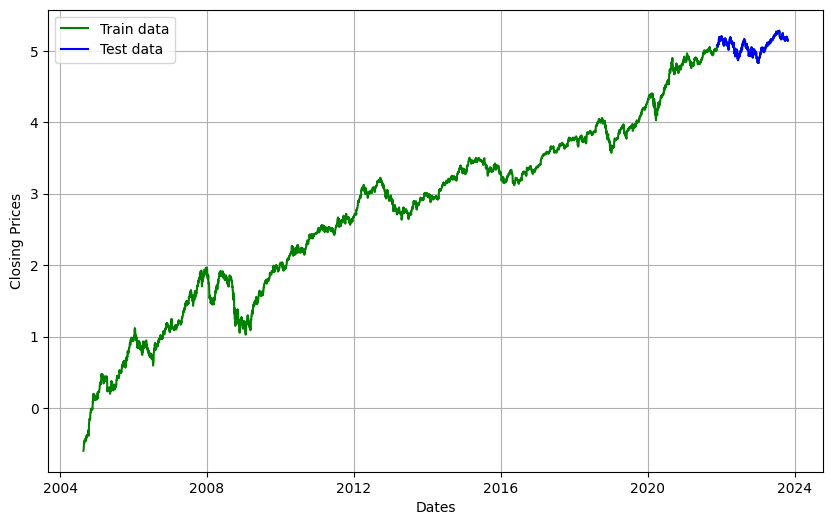

In [16]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21865.436, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.84 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-21218.609, Time=2.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-21216.729, Time=4.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=10281.018, Time=1.51 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=5.50 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.92 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-21217.173, Time=8.72 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 31.546 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4343
Model:               SARIMAX(1, 0, 1)   Log Likelihood               10612.304

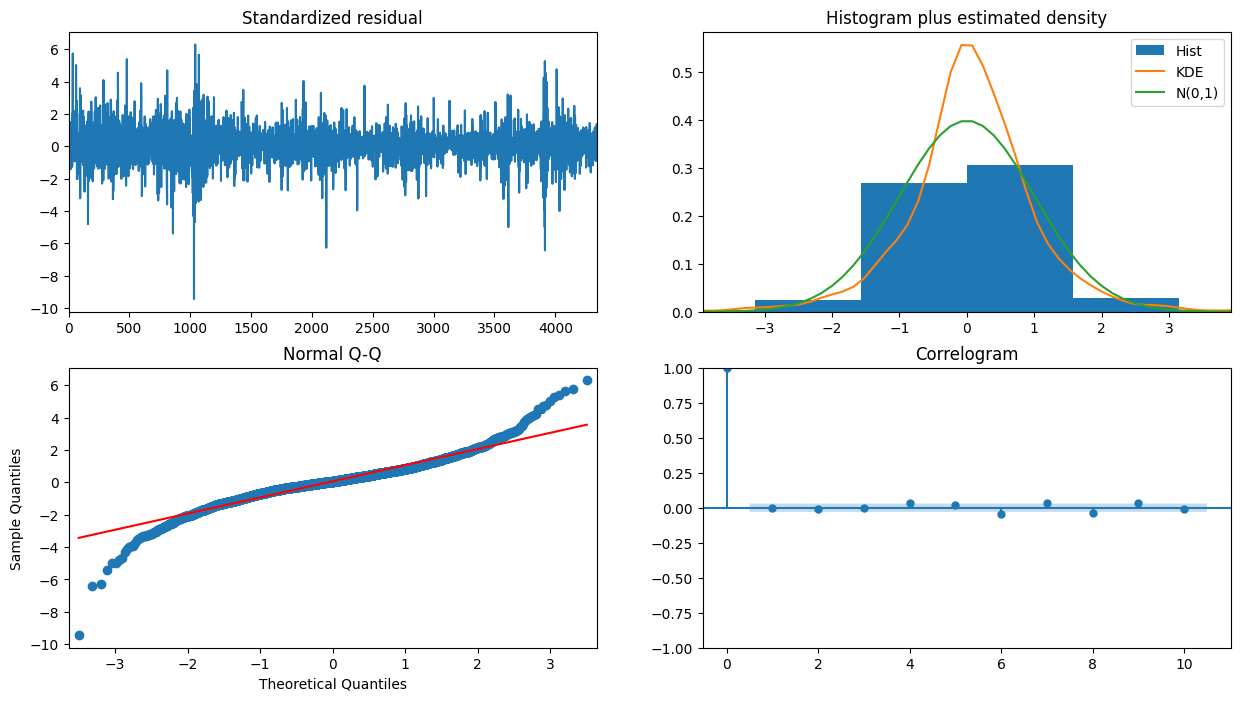

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [33]:
pip install --upgrade statsmodels


In [35]:
# Modeling
# Build Model
model = ARIMA(train_data, order=(1, 1, 2))
fitted = model.fit()
print(fitted.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   APPL   No. Observations:                 4343
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10615.328
Date:                Fri, 27 Oct 2023   AIC                         -21222.657
Time:                        01:07:34   BIC                         -21197.153
Sample:                             0   HQIC                        -21213.654
                               - 4343                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6417      0.506      1.269      0.204      -0.349       1.633
ma.L1         -0.6672      0.506     -1.319      0.187      -1.659       0.324
ma.L2          0.0257      0.013      2.053      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


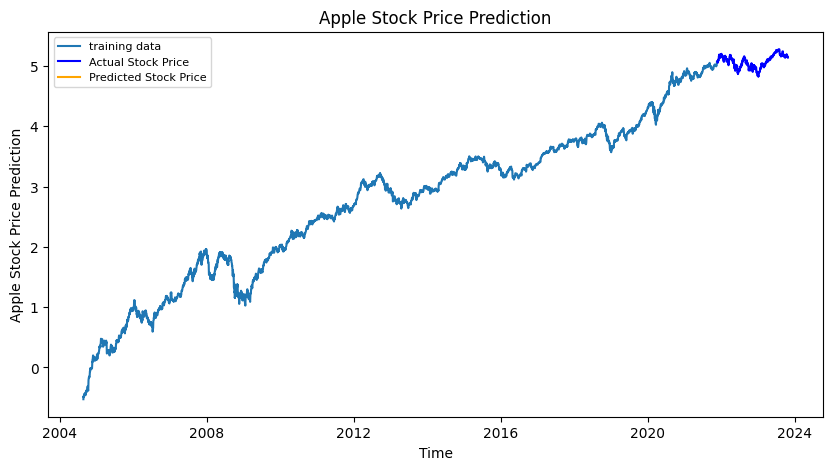

In [37]:
# Forecast
forecast_results = fitted.get_forecast(steps=321, alpha=0.05)
fc = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test_data.index)

# The rest of your code remains the same
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(test_data.index, lower_series, upper_series, color='k', alpha=0.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price Prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()
